<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/Assignment3_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# tutorial
# normal tensors only instantiated when a graph is run and are immediately deleted afterward
# variable survive across multiple executions of a graph, allow you to modify the graph, allow you to add such parameters or nodes to the graph that are trainable. - used for weights and biases.
# Placeholder allow you to feed input on the run. Allow computational graph to take inputs as parameters. - holding the input data and class labels.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
# import scipy.misc as smp
from PIL import Image as im
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Generate Dataset

In [ ]:
def create_circle_random(size = 28, radius = 5, color = 255):
  k = np.random.random_sample(size=2)
  col_random = np.int(16*k[0])+6
  row_random = np.int(16*k[1])+6
  data = np.zeros((size, size), dtype = np.uint8)
  ci,cj = row_random, col_random
  cr = radius
  if(((col_random+cr)>=28) | ((col_random-cr)<1)):
    print("col_random is out of bound")
  if(((row_random+cr)>=28) | ((row_random-cr)<1)):
    print("row_random is out of bound")
  I,J = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
  # basic formula for a circle (x - a)**2 + (y - b)**2 = r**2
  # calculate the radius
  dist = np.sqrt((I-ci)**2 +(J-cj)**2)
  # Assign value of any for those points within radius
  data[np.where(dist<cr)] = color
  # img = im.fromarray(data)
  return data.flatten()

In [ ]:
def rect_x_y(height, width):
  k = np.random.random_sample(size=2)
  start_x = np.int(27*k[0])
  start_y = np.int(27*k[1])
  rows = start_x + height 
  cols = start_y + width
  return start_x, start_y, rows, cols

In [ ]:
def rect_random(size, color):
  data = np.zeros((size, size), dtype = np.uint8)
  # x1, y1, x2, y2 = 0, 0, 0, 0
  x1, y1, x2, y2 = rect_x_y(4, 8)
  # print([x1, y1, x2, y2 ])
  while((x2 >=28)|(y2 >=28)):
    x1, y1, x2, y2 = rect_x_y(4, 8)
  # print([x1, y1, x2, y2 ])
  data[x1:x2, y1:y2] = color
  # img = im.fromarray(data)
  return data.flatten()
  # return img

In [ ]:
def triang_ran(size, color, diagonals = -1):
  data = np.zeros((size, size), dtype = np.uint8)
  # define a rectangle
  start_x, start_y, rows, cols = rect_x_y(8, 8)
  # print([start_x, start_y, rows, cols])
  while((rows >=28)|(cols >=28)):
    start_x, start_y, rows, cols = rect_x_y(8, 8)
  # print([start_x, start_y, rows, cols])
  data[start_x:rows, start_y:cols] = color
  # return lower triangle of rectangle
  data[start_x:rows, start_y:cols] = np.tril(data[start_x:rows, start_y:cols], diagonals)
  # return upper half triangle of rectangle
  # data[start_x:rows, start_y:cols] = np.triu(data[start_x:rows, start_y:cols], diagonals)
  # img = im.fromarray(data)
  # return img
  return data.flatten()

In [ ]:
def random_shape():
  data = np.array([])
  name = ""
  prob = np.random.random_sample()
  if(prob<= 0.33333333333333333):
    data = create_circle_random(28, 5, 255)
    name = "C"
  elif((prob> 0.33333333333333333) & (prob<= 0.66666666666666666)):
    data = rect_random(28, 255)
    name = "R"
  else:
    data = triang_ran(28, 255)
    name = 'T'
  return data, name

In [ ]:
def random_generate(size):
  shape_vect = []
  shape_name = []
  for i in range(size):
    s_vect, s_name = random_shape()
    shape_vect.append(s_vect)
    shape_name.append(s_name)
  num_2d_shape = np.array(shape_vect).reshape(-1, 784)
  return num_2d_shape, shape_name

In [ ]:
train_shape, train_name =  random_generate(3000)
test_shape, test_name =  random_generate(200)

Data transform

In [ ]:
# so the max = 1, and min = 0
train_shape_N = train_shape/255.0
test_shape_N = test_shape/255.0

In [ ]:
# Tensorflow expects a certain input shape for CNN
# (<number of images>, <image x_dim>, <image y_dim>, <number of channels>)
# gray-scale image has only 1 channel
train_shape_R = train_shape_N.reshape(-1, 28, 28, 1)
test_shape_R = test_shape_N.reshape(-1, 28, 28, 1)

Label Encoding + one hot encoding the y variable

In [ ]:
# Mapping 
shape = ['C', "T", "R"]
mapping = {}
for x in range(len(shape)):
  mapping[shape[x]] = x

In [ ]:
# Integer representation
for x in range(len(train_name)):
  train_name[x] = mapping[train_name[x]]

In [ ]:
for x in range(len(test_name)):
  test_name[x] = mapping[test_name[x]]

In [ ]:
# one hot encoding
y = to_categorical(train_name)
y_actual = to_categorical(test_name)

split training and validation set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_shape_R, y, test_size = 0.2, random_state = 0)

Train validation preparation

In [ ]:
batch_sizes = 50
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=3000).batch(batch_sizes)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(batch_sizes)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
def loss_accuracy(train_loss, test_loss, train_accuracy, test_accuracy, title):
  fig, ax = plt.subplots(2, 1, figsize = (12, 10))
  plt.title(title)
  ax[0].plot(train_loss, color = 'b', label = "Training loss")
  ax[0].plot(test_loss, color = 'r', label = 'validation loss', axes = ax[0])
  legend = ax[0].legend(loc = 'best', shadow = True)
  ax[1].plot(train_accuracy, color = 'b', label = 'Training accuracy')
  ax[1].plot( test_accuracy, color = 'r', label = 'validation accuracy')
  ax[1].set_xlabel("Epoch")
  legend = ax[1].legend(loc = 'best', shadow = True)
  plt.show()

Define base model for convolutional neural network

In [ ]:
inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
x1 = Conv2D(filters = 20, kernel_size= (3), strides=(1, 1), padding = "valid", activation='relu', 
            kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
x3 = Flatten()(x2)
x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
outputs = layers.Dense(3, activation = 'softmax')(x4)
model = keras.Model(inputs = inputs, outputs = outputs) 

Base model explain
1. Input $28*28 = 756$
2. Convolution layer: Filter size = $3*3$, filter number = $20$, padding = valid (no padding), stride = $1$(center every element when possible)
3. Convolution output = $26*26 * 20(filters)$: use formula
$$ \frac{n+2*p-f}{s} +1 $$ n = 28(dimension of input), p= 0 (no padding), f = 3 (filter size), s = 1 (stride)   
4. Max pooling layers: Then use max pooling, which has kernel size = $2*2$, and default stride = kernel size.
5. Max pooling output: $13*13 * 20(channels)$ 
6. Flattern output: $13*13*20 = 3380$ input neurons for fully connect network.

Weight size:
1. For convolution layer: $3*3 * 20(filters)$
2. 20 biases for each filter matrix.
3. Max pooling and flatten has no weight or bias to tune.
3. For hidden layer: after flattern input have 3380 neurons and size of this hidden layer $ = 10$, so weight matrix would be $3380 * 10$ then plus a bias vector size = 10 
4. For output layer: Last hidden layer has size of 10, and output layer has size of 3 ( Cycle, triange, rectangle), so the weight matrix is $10*3$ with a bias vector size = 3.

Fitting model

In [ ]:
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
      logits = model(x, training = True)
      # loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y))  
      loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, logits)) 
      # print(loss_value)
  grads = tape.gradient(loss_value, model.trainable_weights)  
  # print(grads)  
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
  train_acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
  return loss_value, train_acc

In [ ]:
@tf.function
def test_step(x, y):
  val_logits = model(x, training = False)
  # val_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= val_logits, labels = y))
  val_loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, val_logits)) 
  val_correct_pred = tf.equal(tf.argmax(val_logits, 1), tf.argmax(y, 1)) # if they are equal
  val_accuracy = tf.reduce_mean(tf.cast(val_correct_pred, tf.float32))
  return val_loss_value, val_accuracy

In [ ]:
epochs = 20
inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
x1 = Conv2D(filters = 20, kernel_size= 3, strides=(1, 1), padding = "valid", activation='relu', 
            kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
x3 = Flatten()(x2)
x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
outputs = layers.Dense(3, activation = 'softmax')(x4)
model = keras.Model(inputs = inputs, outputs = outputs) 

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
  print("\n==============start of epoch %d" %(epoch,))
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    loss_value, train_acc = train_step(x_batch_train, y_batch_train)
    
    if step % 4 ==0:
      print(
          "Training loss (for one batch) at step %d: %.4f"
           %(step, float(loss_value))
      )
      print("Seen so far: %s samples" % ((step+1)*100))

  for x_batch_val, y_batch_val in val_dataset:
    val_loss, val_accuracy = test_step(x_batch_val, y_batch_val)
  print("validation acc: %.4f" %(float(val_accuracy),))
  train_loss.append(loss_value)
  test_loss.append(val_loss)
  train_accuracy.append(train_acc)
  test_accuracy.append(val_accuracy)

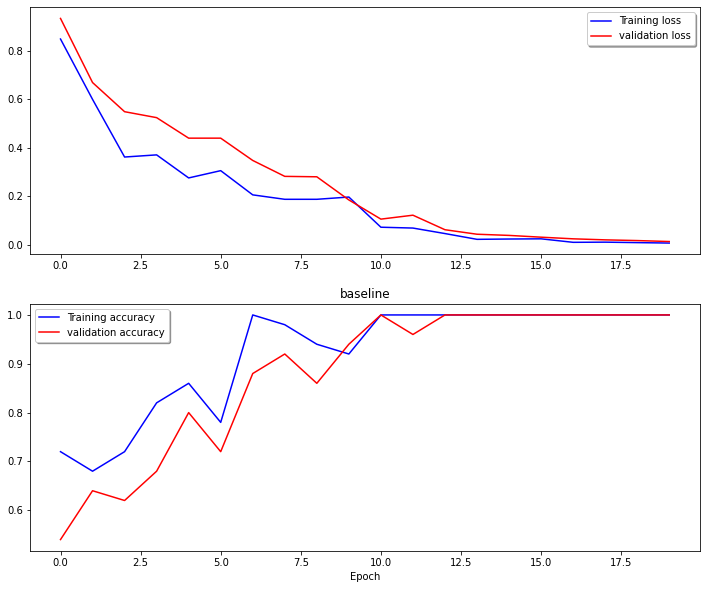

In [ ]:
loss_accuracy(train_loss, test_loss, train_accuracy, test_accuracy, title = 'baseline')

Using 10 epochs, we can see the training accuracy is getting better as epoch increase but test accuracy is not, sign of overfitting.

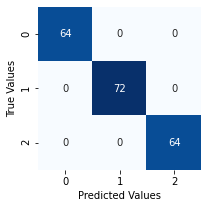

In [ ]:
fig = plt.figure(figsize=(3, 3))
y_pred = model.predict(test_shape_R)
Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_actual, 1)

mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat.T, square=True, annot=True, cbar= False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [ ]:
mapping

{'C': 0, 'R': 2, 'T': 1}

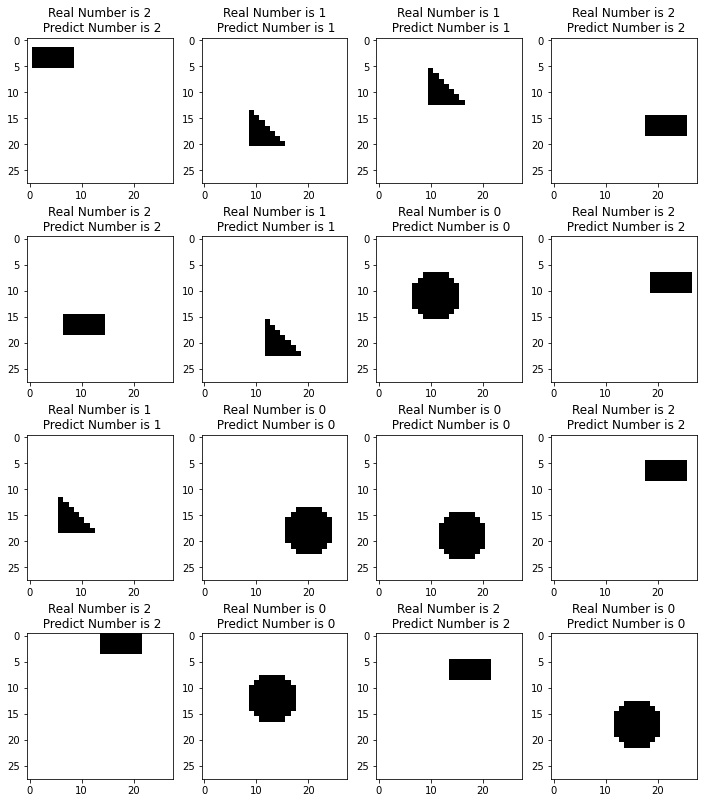

In [ ]:
y_pred = model.predict(test_shape_R)
X_test__ = test_shape_R.reshape(test_shape_R.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(X_test__[i], cmap = 'binary')
  ax.set(title = f'Real Number is {y_actual[i].argmax()}\n Predict Number is {y_pred[i].argmax()}')

#### Model weights
- Look into kernel
- larger the kernel (3*3 vs 9*9), actually 9*9 picked up training accuracy much faster.
- It make sense, you have larger conv-layer, you can train it to memorize(identify) more features (patterns) in 1 conv-layer.

In [ ]:
trained_weight = model.get_weights()

In [ ]:
kernel_weight = trained_weight[0]
# kernel_weight.ndim = 4

In [ ]:
first_k = kernel_weight[:,:,:,0]

In [ ]:
w1 = first_k.reshape(3,3)

In [ ]:
kernel_weight[:,:,:,6].reshape(3,3)

array([[-0.14649613,  0.06947351,  0.00908826],
       [-0.03244866,  0.0979127 , -0.17299734],
       [ 0.06787531,  0.04483287, -0.00237794]], dtype=float32)

In [ ]:
fig, axis = plt.subplots(4, 5, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(kernel_weight[:,:,:,i].reshape(3,3), cmap = 'binary' )

NameError: ignored

In [ ]:
def conv2d_single_channel(input, w):
  assert w.shape[0] == w.shape[1] and w.shape[0] % 2 == 1
  output_size = input.shape[0]-w.shape[0] + 1
  output_1 = np.zeros((output_size, output_size))
  output = np.zeros_like(output_1)
  # print(output.shape)
  for i in range(output.shape[0]):
    for j in range(output.shape[1]):
      for fi in range(w.shape[0]):
        for fj in range(w.shape[1]):
          output[i, j] += input[i + fi, j +fj] * w[fi, fj]
  return output

In [ ]:
test_shape[0].reshape(28,28)

In [ ]:
im.fromarray(test_shape[6].reshape(28,28))

In [ ]:
conv_out = conv2d_single_channel(data, w1)

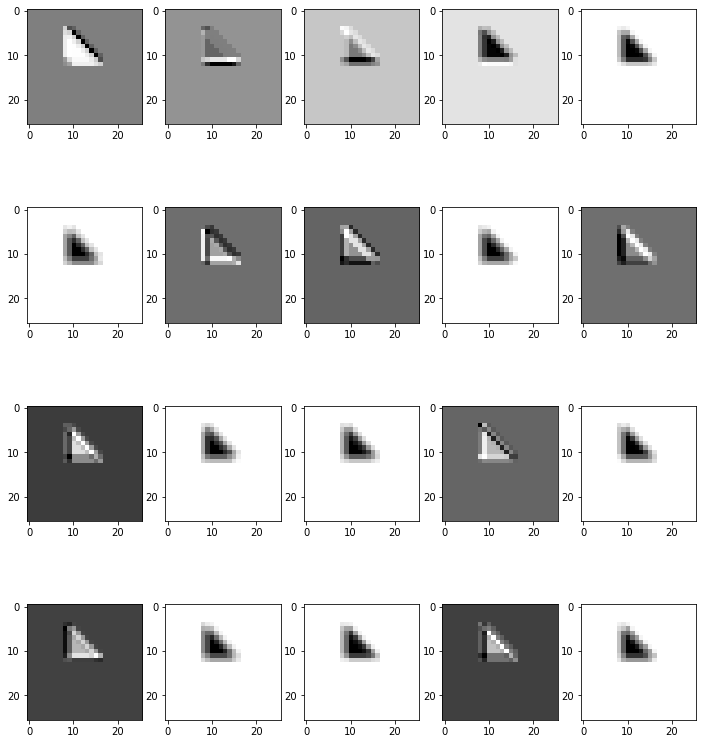

In [ ]:
fig, axis = plt.subplots(4, 5, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(conv2d_single_channel(test_shape[2].reshape(28,28),kernel_weight[:,:,:,i].reshape(3,3)), cmap = 'binary')

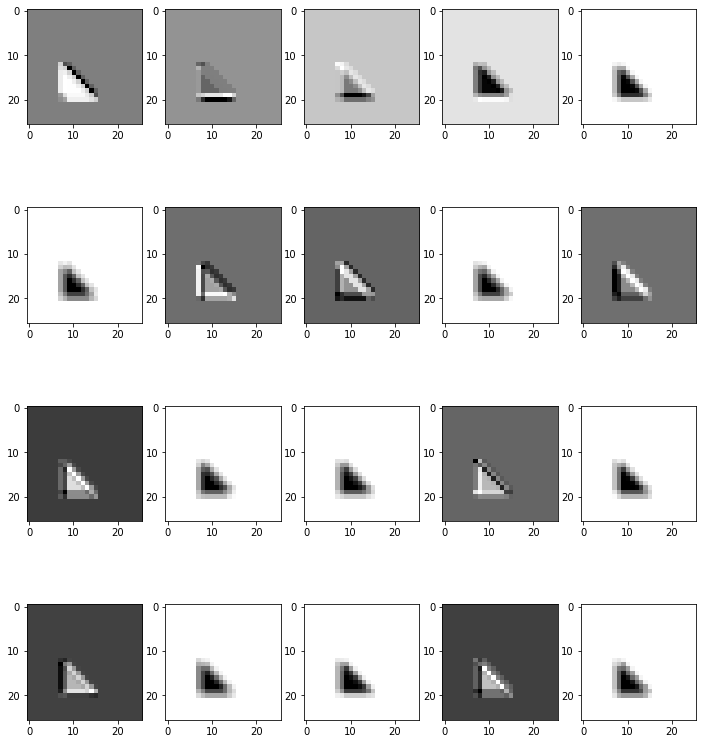

In [ ]:
fig, axis = plt.subplots(4, 5, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(conv2d_single_channel(test_shape[1].reshape(28,28),kernel_weight[:,:,:,i].reshape(3,3)), cmap = 'binary')

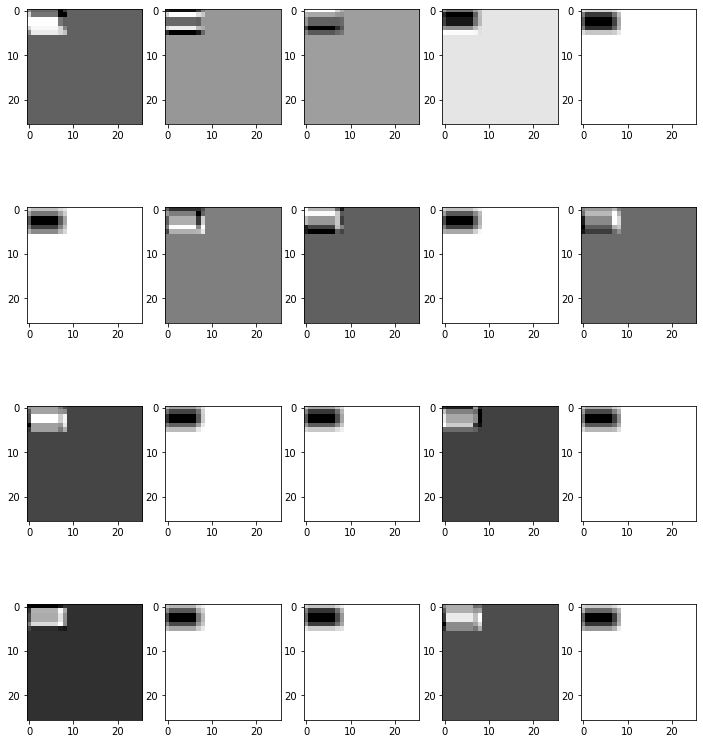

In [ ]:
fig, axis = plt.subplots(4, 5, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(conv2d_single_channel(test_shape[0].reshape(28,28),kernel_weight[:,:,:,i].reshape(3,3)), cmap = 'binary')

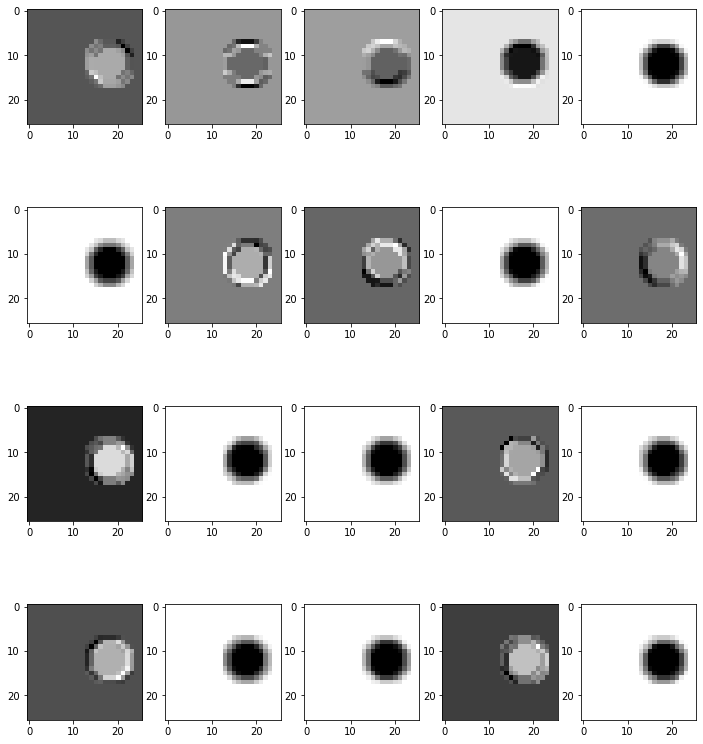

In [ ]:
fig, axis = plt.subplots(4, 5, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(conv2d_single_channel(data,kernel_weight[:,:,:,i].reshape(3,3)), cmap = 'binary')

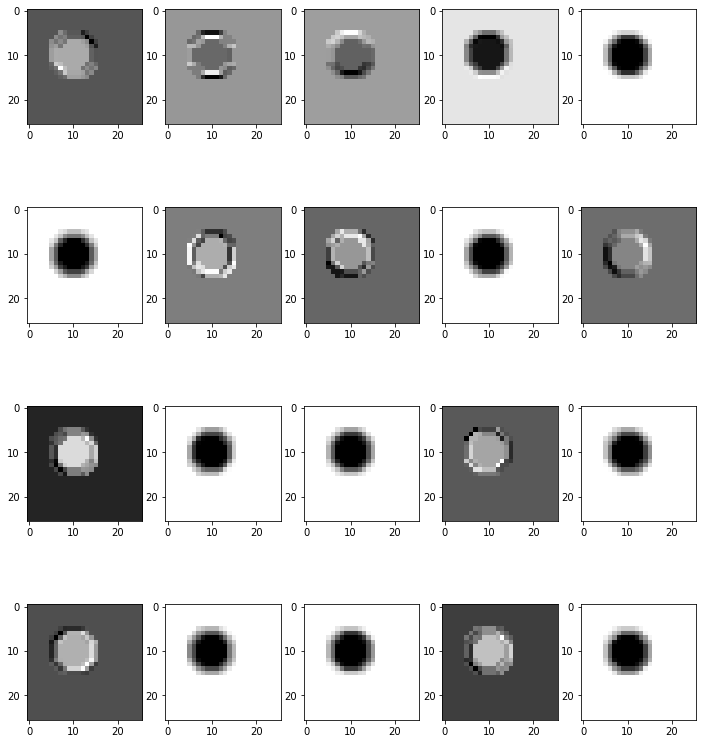

In [ ]:
fig, axis = plt.subplots(4, 5, figsize = (12, 14))
for i, ax in enumerate(axis.flat):
  ax.imshow(conv2d_single_channel(test_shape[6].reshape(28,28),kernel_weight[:,:,:,i].reshape(3,3)), cmap = 'binary')

### Interpretation of kernel matrix
- 1, 3, 10, 19 kernels looks like emboss kernels, they given the illusion of depth by emphasizing the differences of pixels in a given direction.
- 4, 5, 6, 9, 12, 13, 15, 17, 18, 20 are blur kernel, they are duplicated in terms of capturing the same feature of an object.
- 2, 7, 8, 11, 14, 16 kenels looks like sobel (Edge) kernel, but different directions.
  - They are looking for horizontal or vertical component in the image. 

##### Conclusion
- Object is too simple and straight forward, not many features for model to capture.
- Because objects has same orientation all the time, model only need to identify the edge along hypotenuse to recognise triange.
- same happended to cycle and rectangle.
- Therefore, I will varying triangle and rectangle's orientation, also distort the objects so some of object won't be a perfect rectangular shape or triangular shape. 

Tuning number of epochs 

In [ ]:
epochs = 100
inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
x1 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
            kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
x3 = Flatten()(x2)
x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
outputs = layers.Dense(3, activation = 'softmax')(x4)
model = keras.Model(inputs = inputs, outputs = outputs) 

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
  print("\n==============start of epoch %d" %(epoch,))
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train, training = True)
      # loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y))  
      loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_train, logits)) 
      # print(loss_value)
    grads = tape.gradient(loss_value, model.trainable_weights)  
    # print(grads)  
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_batch_train, 1))
    train_acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    if step % 4 ==0:
      print(
          "Training loss (for one batch) at step %d: %.4f"
           %(step, float(loss_value))
      )
      print("Seen so far: %s samples" % ((step+1)*batch_sizes))

  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val, training = False)
  # val_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= val_logits, labels = y))
    val_loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_val, val_logits)) 
    val_correct_pred = tf.equal(tf.argmax(val_logits, 1), tf.argmax(y_batch_val, 1)) # if they are equal
    val_accuracy = tf.reduce_mean(tf.cast(val_correct_pred, tf.float32))
  print("validation acc: %.4f" %(float(val_accuracy),))
  train_loss.append(loss_value)
  test_loss.append(val_loss_value)
  train_accuracy.append(train_acc)
  test_accuracy.append(val_accuracy)

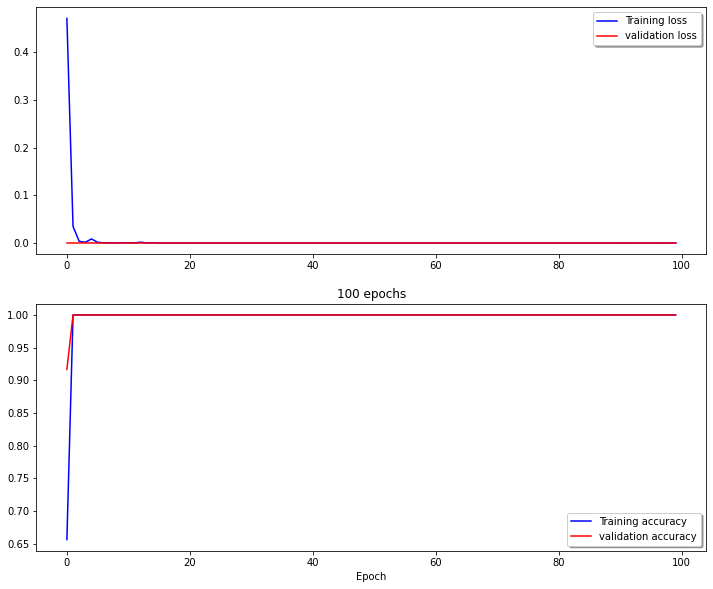

In [ ]:
loss_accuracy(train_loss, test_loss, train_accuracy, test_accuracy, title = '100 epochs')

Colcusion: as we can see, we dont need 100 epochs, accuracy for training and validation reaches to 1 within 20 epochs so use epoch = 20

#### Tuning minibatch
- (10, 30, 50, 70, 100, 200, 500)

In [ ]:
epochs = 20
train_loss_sum = []
test_loss_sum = []
train_accuracy_sum = []
test_accuracy_sum = []
for batchSize in (10, 30, 50, 70, 100, 200, 500):
  batch_sizes = batchSize
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=3000).batch(batch_sizes)
  val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  val_dataset = val_dataset.batch(batch_sizes)

  inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
  x1 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
              kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
  x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
  x3 = Flatten()(x2)
  x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
  outputs = layers.Dense(3, activation = 'softmax')(x4)
  model = keras.Model(inputs = inputs, outputs = outputs) 

  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  for epoch in range(epochs):
    print("\n==============start of epoch %d" %(epoch,))
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      with tf.GradientTape() as tape:
        logits = model(x_batch_train, training = True)
        # loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y))  
        loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_train, logits)) 
        # print(loss_value)
      grads = tape.gradient(loss_value, model.trainable_weights)  
      # print(grads)  
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_batch_train, 1))
      train_acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    for x_batch_val, y_batch_val in val_dataset:
      val_logits = model(x_batch_val, training = False)
    # val_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= val_logits, labels = y))
      val_loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_val, val_logits)) 
      val_correct_pred = tf.equal(tf.argmax(val_logits, 1), tf.argmax(y_batch_val, 1)) # if they are equal
      val_accuracy = tf.reduce_mean(tf.cast(val_correct_pred, tf.float32))
    train_loss.append(loss_value)
    test_loss.append(val_loss_value)
    train_accuracy.append(train_acc)
    test_accuracy.append(val_accuracy)
  train_loss_sum.append(train_loss)
  test_loss_sum.append(test_loss)
  train_accuracy_sum.append(train_accuracy)
  test_accuracy_sum.append(test_accuracy)
  


==============start of epoch 0

==============start of epoch 1

==============start of epoch 2

==============start of epoch 3

==============start of epoch 4

==============start of epoch 5

==============start of epoch 6

==============start of epoch 7

==============start of epoch 8

==============start of epoch 9

==============start of epoch 10

==============start of epoch 11

==============start of epoch 12

==============start of epoch 13

==============start of epoch 14

==============start of epoch 15

==============start of epoch 16

==============start of epoch 17

==============start of epoch 18

==============start of epoch 19

==============start of epoch 0

==============start of epoch 1

==============start of epoch 2

==============start of epoch 3

==============start of epoch 4

==============start of epoch 5

==============start of epoch 6

==============start of epoch 7

==============start of epoch 8

==============start of epoch 9

==============start of epoch 

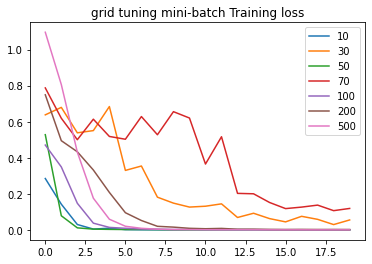

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(train_loss_sum)):
  plt.title('grid tuning mini-batch Training loss')
  plt.plot(train_loss_sum[i], label = (10, 30, 50, 70, 100, 200, 500)[i])
plt.legend()
plt.figure()
plt.show()

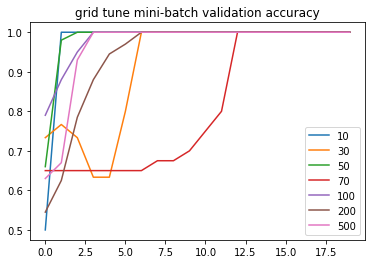

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(test_accuracy_sum)):
  plt.title('grid tune mini-batch validation accuracy')
  plt.plot(test_accuracy_sum[i], label = (10, 30, 50, 70, 100, 200, 500)[i])
plt.legend()
plt.figure()
plt.show()

Conclusion mini-batch tuning
- batch-size between 30 - 50 has better than larger batch size.
- Will choose 50, too small is not taking benefit from the acceleration algorithm, too large network is not update the weights often enough.

Tuning
Architure of model
- the number of conv-pool layers effect(1, 2, 3)
- dropout techniques(0.5, 0.7, 0.9)
- batchnorm vs no batchnorm
- L2?
- max pooling vs average pooling
- padding (valid vs SAME)
- Depthwise speparable convolution vs normal convolution
- change in activation (ReLU, Tanh, sigmoid, softmax)
- Filter number
- Filter size
- hidden layer number
- hidden layer size

In [ ]:
# 1
epochs = 20
inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
x1 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
            kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
x3 = Flatten()(x2)
x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
outputs = layers.Dense(3, activation = 'softmax')(x4)
model = keras.Model(inputs = inputs, outputs = outputs) 

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
  print("\n==============start of epoch %d" %(epoch,))
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train, training = True)
      # loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y))  
      loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_train, logits)) 
      # print(loss_value)
    grads = tape.gradient(loss_value, model.trainable_weights)  
    # print(grads)  
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_batch_train, 1))
    train_acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    if step % 4 ==0:
      print(
          "Training loss (for one batch) at step %d: %.4f"
           %(step, float(loss_value))
      )
      print("Seen so far: %s samples" % ((step+1)*batch_sizes))

  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val, training = False)
  # val_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= val_logits, labels = y))
    val_loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_val, val_logits)) 
    val_correct_pred = tf.equal(tf.argmax(val_logits, 1), tf.argmax(y_batch_val, 1)) # if they are equal
    val_accuracy = tf.reduce_mean(tf.cast(val_correct_pred, tf.float32))
  print("validation acc: %.4f" %(float(val_accuracy),))
  train_loss.append(loss_value)
  test_loss.append(val_loss_value)
  train_accuracy.append(train_acc)
  test_accuracy.append(val_accuracy)


==============start of epoch 0
Training loss (for one batch) at step 0: 1.1101
Seen so far: 500 samples
Training loss (for one batch) at step 4: 1.0042
Seen so far: 2500 samples
validation acc: 0.3600

==============start of epoch 1
Training loss (for one batch) at step 0: 0.9674
Seen so far: 500 samples
Training loss (for one batch) at step 4: 0.7888
Seen so far: 2500 samples
validation acc: 0.6700

==============start of epoch 2
Training loss (for one batch) at step 0: 0.7405
Seen so far: 500 samples
Training loss (for one batch) at step 4: 0.6933
Seen so far: 2500 samples
validation acc: 0.7600

==============start of epoch 3
Training loss (for one batch) at step 0: 0.6661
Seen so far: 500 samples
Training loss (for one batch) at step 4: 0.6925
Seen so far: 2500 samples
validation acc: 0.7400

==============start of epoch 4
Training loss (for one batch) at step 0: 0.6500
Seen so far: 500 samples
Training loss (for one batch) at step 4: 0.6320
Seen so far: 2500 samples
validation ac

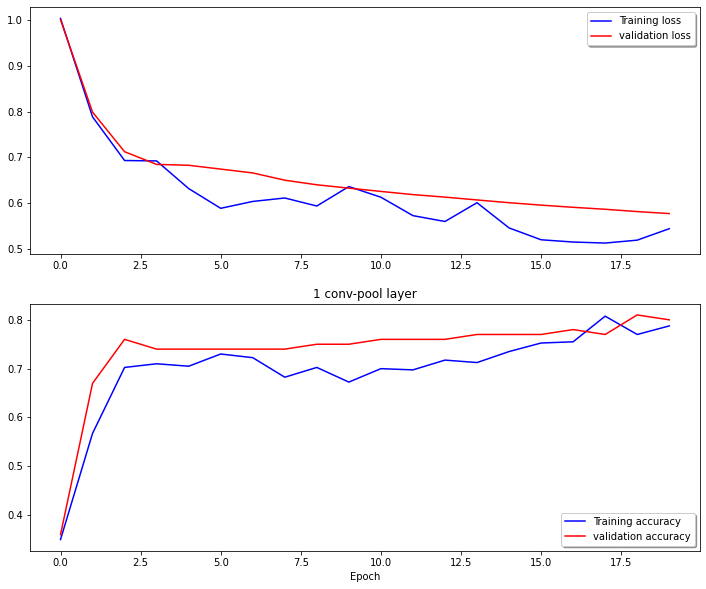

In [ ]:
loss_accuracy(train_loss, test_loss, train_accuracy, test_accuracy, title = '1 conv-pool layer')

In [ ]:
# 1
epochs = 20
inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
x1 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
            kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
x11 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
            kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(x2)
x22 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x11)
x3 = Flatten()(x22)
x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
outputs = layers.Dense(3, activation = 'softmax')(x4)
model = keras.Model(inputs = inputs, outputs = outputs) 

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
  print("\n==============start of epoch %d" %(epoch,))
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train, training = True)
      # loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y))  
      loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_train, logits)) 
      # print(loss_value)
    grads = tape.gradient(loss_value, model.trainable_weights)  
    # print(grads)  
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_batch_train, 1))
    train_acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    if step % 4 ==0:
      print(
          "Training loss (for one batch) at step %d: %.4f"
           %(step, float(loss_value))
      )
      print("Seen so far: %s samples" % ((step+1)*batch_sizes))

  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val, training = False)
  # val_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= val_logits, labels = y))
    val_loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_val, val_logits)) 
    val_correct_pred = tf.equal(tf.argmax(val_logits, 1), tf.argmax(y_batch_val, 1)) # if they are equal
    val_accuracy = tf.reduce_mean(tf.cast(val_correct_pred, tf.float32))
  print("validation acc: %.4f" %(float(val_accuracy),))
  train_loss.append(loss_value)
  test_loss.append(val_loss_value)
  train_accuracy.append(train_acc)
  test_accuracy.append(val_accuracy)


==============start of epoch 0
Training loss (for one batch) at step 0: 1.1740
Seen so far: 500 samples
Training loss (for one batch) at step 4: 1.0957
Seen so far: 2500 samples
validation acc: 0.3700

==============start of epoch 1
Training loss (for one batch) at step 0: 1.0968
Seen so far: 500 samples
Training loss (for one batch) at step 4: 1.0485
Seen so far: 2500 samples
validation acc: 0.2600

==============start of epoch 2
Training loss (for one batch) at step 0: 1.0418
Seen so far: 500 samples
Training loss (for one batch) at step 4: 1.0117
Seen so far: 2500 samples
validation acc: 0.2200

==============start of epoch 3
Training loss (for one batch) at step 0: 1.0168
Seen so far: 500 samples
Training loss (for one batch) at step 4: 0.9545
Seen so far: 2500 samples
validation acc: 0.2800

==============start of epoch 4
Training loss (for one batch) at step 0: 0.9122
Seen so far: 500 samples
Training loss (for one batch) at step 4: 0.8459
Seen so far: 2500 samples
validation ac

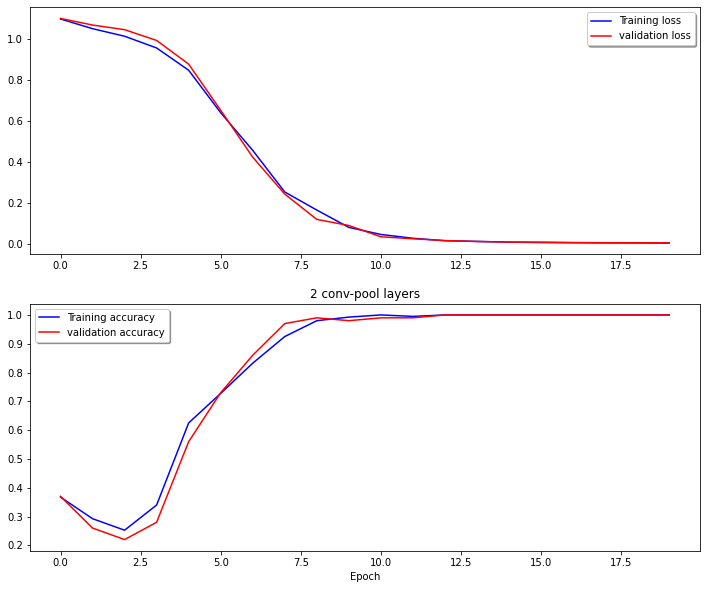

In [ ]:
loss_accuracy(train_loss, test_loss, train_accuracy, test_accuracy, title = '2 conv-pool layers')

Conv-pool layer tuning
- By holding other hyperparameters constant.
- As we can see, loss plot shows 2 conv-pool layers converges much faster than 1  conv-pool layer.
- This is same architectures as the LeNet-5.
- convolution layer has no padding (valid), so the size of input is very small (size = 5) after 2nd conv-pool layers.

Regularization

Drop out tuning
- previous 2 conv-pool model is the baseline of no drop out
- tuning dropout = (0.2, 0.5, 0.7)

In [ ]:
# 1
epochs = 20
train_loss_sum = []
test_loss_sum = []
train_accuracy_sum = []
test_accuracy_sum = []
for dropout in (0.2, 0.5, 0.7):
  inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
  x1 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
              kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
  x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
  x221 = Dropout(dropout)(x2)
  x11 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
              kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(x221)
  x22 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x11)
  x222 = Dropout(dropout)(x22)
  x3 = Flatten()(x222)
  x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
  outputs = layers.Dense(3, activation = 'softmax')(x4)
  model = keras.Model(inputs = inputs, outputs = outputs) 

  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  for epoch in range(epochs):
    print("\n==============start of epoch %d" %(epoch,))
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      with tf.GradientTape() as tape:
        logits = model(x_batch_train, training = True)
        # loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y))  
        loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_train, logits)) 
        # print(loss_value)
      grads = tape.gradient(loss_value, model.trainable_weights)  
      # print(grads)  
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_batch_train, 1))
      train_acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    for x_batch_val, y_batch_val in val_dataset:
      val_logits = model(x_batch_val, training = False)
    # val_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= val_logits, labels = y))
      val_loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_val, val_logits)) 
      val_correct_pred = tf.equal(tf.argmax(val_logits, 1), tf.argmax(y_batch_val, 1)) # if they are equal
      val_accuracy = tf.reduce_mean(tf.cast(val_correct_pred, tf.float32))
    train_loss.append(loss_value)
    test_loss.append(val_loss_value)
    train_accuracy.append(train_acc)
    test_accuracy.append(val_accuracy)
  train_loss_sum.append(train_loss)
  test_loss_sum.append(test_loss)
  train_accuracy_sum.append(train_accuracy)
  test_accuracy_sum.append(test_accuracy)


==============start of epoch 0

==============start of epoch 1

==============start of epoch 2

==============start of epoch 3

==============start of epoch 4

==============start of epoch 5

==============start of epoch 6

==============start of epoch 7

==============start of epoch 8

==============start of epoch 9

==============start of epoch 10

==============start of epoch 11

==============start of epoch 12

==============start of epoch 13

==============start of epoch 14

==============start of epoch 15

==============start of epoch 16

==============start of epoch 17

==============start of epoch 18

==============start of epoch 19

==============start of epoch 0

==============start of epoch 1

==============start of epoch 2

==============start of epoch 3

==============start of epoch 4

==============start of epoch 5

==============start of epoch 6

==============start of epoch 7

==============start of epoch 8

==============start of epoch 9

==============start of epoch 

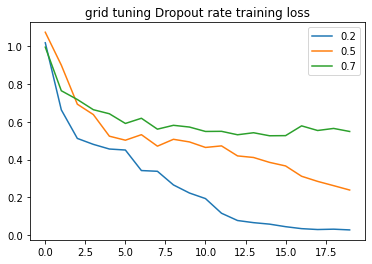

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(train_loss_sum)):
  plt.title('grid tuning Dropout rate training loss')
  plt.plot(train_loss_sum[i], label = (0.2, 0.5, 0.7)[i])
plt.legend()
plt.figure()
plt.show()

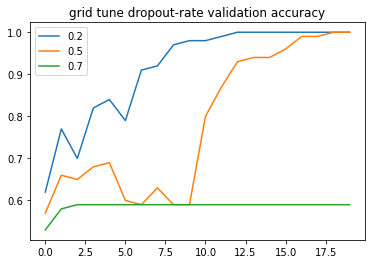

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(test_accuracy_sum)):
  plt.title('grid tune dropout-rate validation accuracy')
  plt.plot(test_accuracy_sum[i], label = (0.2, 0.5, 0.7)[i])
plt.legend()
plt.figure()
plt.show()

Drop out rate tuning conclusion
- plot of training loss shows as dropout rate increase, model needs more epochs to converge.
- Validation accuracy shows the same pattern.
- however, the validation accuracy for dropout rate = 0.2 reaches to 1 almost fater than baseline no dropout, so we will use dropout = 0.2 in baseline model.

Bathnorm2d()

In [ ]:
  inputs = keras.Input(shape = (28, 28, 1), name = 'shape')
  x1 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
              kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(inputs)
  x2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x1)
  x221 = Dropout(dropout)(x2)
  x11 = Conv2D(filters = 20, kernel_size= (3*3), strides=(1, 1), padding = "valid", activation='relu', 
              kernel_initializer='glorot_uniform', use_bias=True, bias_initializer='glorot_uniform', kernel_regularizer=None)(x221)
  x22 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x11)
  x222 = Dropout(dropout)(x22)
  x3 = Flatten()(x222)
  x4 = layers.Dense(10, activation = 'relu', kernel_initializer='glorot_uniform', use_bias=True, bias_initializer="glorot_uniform", kernel_regularizer=None)(x3)
  outputs = layers.Dense(3, activation = 'softmax')(x4)
  model = keras.Model(inputs = inputs, outputs = outputs) 